# Loading Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from POLO.PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from POLO.PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor
from utils import view_data
from typing import List, Tuple

Default lg shape= 32 32


In [2]:
#args.offset_std = 30
#args.contrast = 0.7

width = {'in': 32, 'out': 64}

n_levels = {'in': 3, 'out': 3} 

base_levels = 2

n_color = {'in': 3, 'out': 3}

color = True

color_mode= 'rgb' #'lab' # 'hsv' #True

r_min = {'in': width['in'] / 4, 'out': width['out'] / 4}

r_max = {'in': width['in'] / 2, 'out': width['out'] / 2}

n_sublevel = n_eccentricity = {'in': 2, 'out': 4}

n_azimuth = {'in': 16, 'out': 32}

n_theta = {'in': 8, 'out': 8}

n_phase = {'in': 1, 'out': 1}

do_mask = False

gauss = False






In [3]:
lg={}
for k in ['in', 'out']:
    pe = {'N_X': width[k], 'N_Y': width[k], 'do_mask': do_mask, 'base_levels':
              base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
          'use_cache': True, 'figpath': 'results', 'edgefigpath':
              'results/edges', 'matpath': 'cache_dir', 'edgematpath':
              'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
              14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

    lg[k] = LogGabor(pe)

In [4]:
K = {}
for k in ['in', 'out']:
    K[k] = get_K(width=width[k],
          n_sublevel = n_sublevel[k], 
          n_azimuth = n_azimuth[k], 
          n_theta = n_theta[k],
          n_phase = n_phase[k], 
          r_min = r_min[k], 
          r_max = r_max[k], 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg[k])

i_sublevel, sf_0, radius 0 0.36067376022224085 8.0
i_sublevel, sf_0, radius 1 0.25503486164919736 11.31370849898476
K shape= torch.Size([32, 32, 2, 16, 8, 1])
K min max= tensor(-0.3125) tensor(1.)
i_sublevel, sf_0, radius 0 0.18033688011112042 16.0
i_sublevel, sf_0, radius 1 0.15164463602348005 19.027313840043536
i_sublevel, sf_0, radius 2 0.12751743082459868 22.62741699796952
i_sublevel, sf_0, radius 3 0.10722895046276856 26.908685288118864
K shape= torch.Size([64, 64, 4, 32, 8, 1])
K min max= tensor(-0.2759) tensor(1.)


In [5]:
K_inv={}
for k in ['in', 'out']:
    K_inv[k] = get_K_inv(K[k], 
                  width=width[k], 
                  n_sublevel = n_sublevel[k], 
                  n_azimuth = n_azimuth[k], 
                  n_theta = n_theta[k], 
                  n_phase = n_phase[k])

Filter tensor shape= torch.Size([32, 32, 2, 16, 8, 1])
Reshaped filter tensor= torch.Size([1024, 256])
Tensor shape= torch.Size([256, 1024])
Filter tensor shape= torch.Size([64, 64, 4, 32, 8, 1])
Reshaped filter tensor= torch.Size([4096, 1024])
Tensor shape= torch.Size([1024, 4096])


# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [6]:
args = init(filename='2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

In [7]:
class DualCroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode

    def __call__(self, img):
        img_crop = {}
        for k in ['in', 'out']:
            img_crop_part, level_size = cropped_pyramid(img.unsqueeze(0), 
                                               width=self.width[k], 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels[k],
                                               color_mode=self.color_mode)
            #print(img_crop_part.shape)
            img_crop[k] = img_crop_part[:self.n_levels[k]-1,...]
        return img, img_crop   

### LogGaborTransform

In [8]:
class DualLogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose

    def __call__(self, cropped_pyr):
        img = cropped_pyr[0]
        img_crop = cropped_pyr[1]
        log_gabor_coeffs = {}
        for k in ['in', 'out']:
            log_gabor_coeffs[k] = log_gabor_transform(img_crop[k].unsqueeze(1), K[k], color=self.color).squeeze(1)
        
        return img, log_gabor_coeffs

In [9]:
class DualLogGaborReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose

    def __call__(self, log_gabor_transform):
        img = log_gabor_transform[0]
        log_gabor_coeffs = log_gabor_transform[1]
        for k in ['in', 'out']:
            # n_batch, n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase
            # x      , 0       , 1      , 2         , 3        , 4      , 5
            # 
            #print(log_gabor_coeffs[k].shape)
            log_gabor_coeffs[k] = log_gabor_coeffs[k].permute(1, 4, 5, 0, 2, 3).contiguous()
            log_gabor_coeffs[k] = log_gabor_coeffs[k].view(self.n_color[k]*self.n_theta[k]*self.n_phase[k], 
                                                     (self.n_levels[k]-1) * self.n_eccentricity[k], 
                                                     self.n_azimuth[k])
 
        return img, log_gabor_coeffs

In [10]:
class LogGaborInvReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):

        if self.verbose:
            print('log_gabor_coeffs.shape:', log_gabor_coeffs.shape)
        log_gabor_coeffs = log_gabor_coeffs.view(-1, 
                                                 self.n_color, 
                                                 self.n_theta, 
                                                 self.n_phase, 
                                                 self.n_levels, 
                                                 self.n_eccentricity, 
                                                 self.n_azimuth)
        log_gabor_coeffs = log_gabor_coeffs.permute(0, 4, 1, 5, 6, 2, 3).contiguous()
        return log_gabor_coeffs

In [11]:
class LogGaborInvTransform(object):
    def __init__(self, K_inv=K_inv, color=color, verbose=False):
        self.K_inv = K_inv
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):
        img_crop=inverse_gabor(log_gabor_coeffs[:, :, 0, ...].detach(), self.K_inv, self.verbose)
        if self.verbose:
            print('img_crop.shape:', img_crop.shape)

        return img_crop

In [12]:
class InvCroppedPyramid(object):
    def __init__(self, 
                 #width, 
                 base_levels, 
                 color=color, 
                 #do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb',
                 N_X = 128,
                 N_Y = 128):
        #self.width = width
        self.base_levels = base_levels
        self.color = color
        #self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode
        self.N_X = N_X
        self.N_Y = N_Y

    def __call__(self, img_crop):
        full_img_rec = inverse_pyramid(img_crop, 
                                       N_X = self.N_X,
                                       N_Y = self.N_Y,
                                       #width=self.width, 
                                       base_levels=self.base_levels,
                                       color=self.color, 
                                       #do_mask=self.do_mask, 
                                       verbose=self.verbose,
                                       #squeeze=True,
                                       gauss=gauss,
                                       n_levels=self.n_levels) #,
                                       #color_mode=self.color_mode)
        return full_img_rec

### Inverse transformations (for display only)

# Exploring the MNIST with where noise parameters and log polar encoding

- 128x128 pixel with shift, noise and circular mask

In [13]:
#args.offset_max = 40 #like in the paper

In [14]:
# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
v_mean = np.array([0.485, 0.456, 0.406])
v_std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=v_mean, std=v_std) # to normalize colors on the imagenet dataset



In [15]:
image_size = 256

transform_big =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            #transforms_norm, 
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

In [16]:
width,base_levels, color, n_levels

({'in': 32, 'out': 64}, 2, True, {'in': 3, 'out': 3})

In [17]:
image_path = "../data/animal/"

image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train', 
                            transform=transform_big
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'test', 
                            transform=transform_big
                        )
                }

In [18]:
dataset_size = {'train' : len(image_dataset['train']),
                'test' : len(image_dataset['test'])}

dataset_size['train'], dataset_size['test']

(2000, 1200)

In [19]:
batch_size = 50
num_workers = 1

dataloader = { 'train' : torch.utils.data.DataLoader(
                            image_dataset['train'], batch_size=batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            image_dataset['test'], batch_size=batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [20]:
data, label = next(iter(dataloader['train']))

In [21]:
data_original = data[0]
data_polo = data[1]
data_original.shape, data_polo['in'].shape, data_polo['out'].shape

(torch.Size([50, 3, 256, 256]),
 torch.Size([50, 24, 4, 16]),
 torch.Size([50, 24, 8, 32]))

In [22]:
# n_batch, n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase

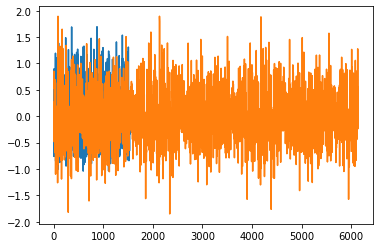

In [23]:
plt.plot(data_polo['in'][3,...].detach().numpy().flatten())
plt.plot(data_polo['out'][3,...].detach().numpy().flatten())


### Displaying Log Gabor Encoded visual field using pseudo-inverse transformation

In [24]:
inverse_transform = {}
for k in ['in', 'out']:
    N_X = N_Y = width[k] * 2**(n_levels[k]-1)
    print(N_X)
    inverse_transform[k] = transforms.Compose([
        LogGaborInvReshape(n_levels[k], n_color[k], n_eccentricity[k], n_azimuth[k], n_theta[k], n_phase[k], color=color, verbose=False),        
        LogGaborInvTransform(K_inv=K_inv[k], color=color, verbose=False),
        InvCroppedPyramid(base_levels, n_levels=n_levels[k], verbose=False, N_X=N_X, N_Y=N_Y),
    ])

128
256


- The Log-Polar compressed format

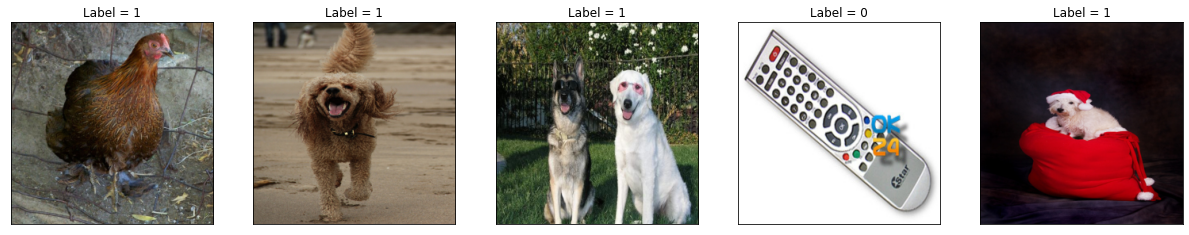

In [25]:
original = view_data(data_original, label, 5)

In [26]:
inverse_transform['in']

Compose(
)

- The original format

In [27]:
data_polo['in'].shape, data_polo['out'].shape

(torch.Size([50, 24, 4, 16]), torch.Size([50, 24, 8, 32]))

# Creating an Attention Transformer model with log-polar entry (POLO-STN)

In [28]:
transform_in =  transforms.Compose([
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

In [194]:
class Polo_AttentionTransNet(nn.Module):
    
    def __init__(self, do_stn=True):
        super(Polo_AttentionTransNet, self).__init__()
        
        self.do_stn = do_stn

        ##  The what pathway
        #self.wloc1 = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
        #                      50, 3, padding=1)
        #self.wloc2a = nn.Conv2d(50, 100, 3, padding=1)
        #self.wloc2b = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
        #                       50, 3, padding=1)
        self.wloc3 = nn.Linear((n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2 * (50+100), 
                              500)
        self.wloc4 = nn.Linear(500, 2)

        #self.wloc4.weight.data.zero_()
        #self.wloc4.bias.data.zero_()

                
        ##  The where pathway        
        self.loc1 = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              50, 5, padding=2)
        self.loc2a = nn.Conv2d(50, 100, 5, padding=2)
        self.loc2b = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                               50, 5, padding=2)
        self.loc3 = nn.Linear((n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2 * (50+100), 
                              500)
        self.loc4 = nn.Linear(500, 2) #, bias=False)

        #self.loc4.weight.data.zero_()
        #self.loc4.bias.data.zero_()

        self.downscale = nn.Parameter(torch.tensor([[1, 0], [0, 1]],
                                                   dtype=torch.float),
                                      requires_grad=False)

    def stn(self: object, x: torch.Tensor, x_polo: torch.Tensor) -> Tuple[torch.Tensor]:
    
        if self.do_stn:
            xs_part = {}
            #for k in ['in', 'out']:
            #    print(x_polo[k].shape)
            #    xs_part[k] = x_polo[k].permute(0,2,5,6,1,3,4)
            #    xs_part[k] = xs_part[k].view(-1, n_color[k] * n_theta[k] * n_phase[k], 
            #                                 (n_levels[k]-1) * n_eccentricity[k], 
            #                                 n_azimuth[k])

            #print(x_polo['out'].shape)

            with torch.no_grad():
                xs = F.relu(self.loc1(x_polo['out']))
                xs = nn.MaxPool2d(2)(xs)        

                #print(xs.shape)

                xsa = F.relu(self.loc2a(xs))
                xsa = nn.MaxPool2d(2)(xsa)

                #print(xsa.shape)

                xsb = F.relu(self.loc2b(x_polo['in']))
                xsb = nn.MaxPool2d(2)(xsb)

                #print(xsb.shape)

                xs = torch.cat((xsa, xsb), dim=1)
            xs = F.relu(self.loc3(xs.view(-1, 
                                          (50+100) * (n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2)))
            #theta = F.sigmoid(self.loc4(xs)) - 0.5
            theta = self.loc4(xs)
            print(theta[0,...])
            theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                theta.size(0), 1, 1), theta.unsqueeze(2)),
                                  dim=2)
        
            grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
            grid = F.affine_grid(theta, grid_size)
            x = F.grid_sample(x, grid)

        else:
            theta = nn.Parameter(torch.tensor([[1, 0, 0], [0, 1, 0]],
                                                   dtype=torch.float),
                                      requires_grad=False)
            theta = theta.unsqueeze(0).repeat(x.size()[0], 1, 1)
        return x, theta

    def forward(self, x, x_polo):
        # transform the input
        x, _ = self.stn(x, x_polo)
        
        if self.do_stn:
        
            w_x_polo ={'in': torch.zeros_like(x_polo['in']),
                       'out': torch.zeros_like(x_polo['out'])}
            for i in range(batch_size):
                d, w = transform_in(x[i,...])
                w_x_polo['in'][i,...] = w['in']
                w_x_polo['out'][i,...] = w['out']
        else:
            w_x_polo = x_polo
                                           

        # print(x.shape)
        # Perform the usual forward pass
        ya = F.relu(self.loc1(w_x_polo['out']))
        ya = nn.MaxPool2d(2)(ya)        
        
        #print(xs.shape)
        
        ya = F.relu(self.loc2a(ya))
        ya = nn.MaxPool2d(2)(ya)
        
        #print(xsa.shape)
        
        yb = F.relu(self.loc2b(w_x_polo['in']))
        yb = nn.MaxPool2d(2)(yb)
        
        #print(xsb.shape)

        y = torch.cat((ya, yb), dim=1)
        y = F.relu(self.wloc3(y.view(-1, (50+100) * (n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2)))
        y = self.wloc4(y)
        return y

In [195]:
def train(epoch, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):

        data_original, data_polo = data[0], data[1]
        data_original, data_polo['in'], data_polo['out'], target = data_original.to(
            device, dtype=torch.double), data_polo['in'].to(
                device, dtype=torch.double), data_polo['out'].to(
                device, dtype=torch.double), target.to(device)

        optimizer.zero_grad()
        output = model(data_original, data_polo)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data_original),
                len(dataloader['train'].dataset),
                100. * batch_idx / len(dataloader['train']), loss.item()))


def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data_original, data_polo = data[0], data[1]
            data_original = data_original.to(device, dtype=torch.double)            
            data_polo['in'] = data_polo['in'].to(device, dtype=torch.double) 
            data_polo['out'] = data_polo['out'].to(device, dtype=torch.double) 
            target = target.to(device)

            output = model(data_original, data_polo)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(dataloader['test'].dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(dataloader['test'].dataset),
                     100. * correct / len(dataloader['test'].dataset)))
        return correct / len(dataloader['test'].dataset)

# Training 

In [196]:
lr = 1e-4

In [197]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = torch.load("../models/low_comp_polo_stn.pt")
model = Polo_AttentionTransNet().to(device)

In [198]:
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, last_epoch=-1) #, verbose=True)

In [199]:
acc = []

In [200]:
args.epochs = 100
model.do_stn = False
for epoch in range(1, args.epochs + 1):
    train(epoch, dataloader['train'])
    curr_acc = test(dataloader['test'])
    acc.append(curr_acc)
    #scheduler.step()

Train Epoch: 1/100 [0/2000 (0%)]	Loss: 0.691332

Test set: Average loss: 0.0138, Accuracy: 599/1200 (50%)

Train Epoch: 2/100 [0/2000 (0%)]	Loss: 0.685091

Test set: Average loss: 0.0137, Accuracy: 666/1200 (56%)

Train Epoch: 3/100 [0/2000 (0%)]	Loss: 0.666789

Test set: Average loss: 0.0136, Accuracy: 643/1200 (54%)

Train Epoch: 4/100 [0/2000 (0%)]	Loss: 0.669566

Test set: Average loss: 0.0134, Accuracy: 720/1200 (60%)

Train Epoch: 5/100 [0/2000 (0%)]	Loss: 0.625396

Test set: Average loss: 0.0131, Accuracy: 733/1200 (61%)

Train Epoch: 6/100 [0/2000 (0%)]	Loss: 0.578502

Test set: Average loss: 0.0129, Accuracy: 733/1200 (61%)

Train Epoch: 7/100 [0/2000 (0%)]	Loss: 0.501147

Test set: Average loss: 0.0126, Accuracy: 766/1200 (64%)

Train Epoch: 8/100 [0/2000 (0%)]	Loss: 0.422583

Test set: Average loss: 0.0127, Accuracy: 793/1200 (66%)

Train Epoch: 9/100 [0/2000 (0%)]	Loss: 0.316520

Test set: Average loss: 0.0131, Accuracy: 778/1200 (65%)

Train Epoch: 10/100 [0/2000 (0%)]	Los

KeyboardInterrupt: 

In [201]:
args.epochs = 100
model.do_stn = True
for epoch in range(1, args.epochs + 1):
    train(epoch, dataloader['train'])
    curr_acc = test(dataloader['test'])
    acc.append(curr_acc)
    #scheduler.step()

tensor([-0.0586, -0.0053], grad_fn=<SelectBackward0>)
Train Epoch: 1/100 [0/2000 (0%)]	Loss: 0.561185
tensor([-0.1488, -0.2022], grad_fn=<SelectBackward0>)
tensor([-0.0096, -0.3316], grad_fn=<SelectBackward0>)
tensor([ 0.0418, -0.2807], grad_fn=<SelectBackward0>)
tensor([ 0.1340, -0.4616], grad_fn=<SelectBackward0>)
tensor([ 0.0851, -0.2195], grad_fn=<SelectBackward0>)
tensor([ 0.2529, -0.3252], grad_fn=<SelectBackward0>)
tensor([ 0.2716, -0.3449], grad_fn=<SelectBackward0>)
tensor([ 0.1203, -0.1929], grad_fn=<SelectBackward0>)
tensor([ 0.2487, -0.2527], grad_fn=<SelectBackward0>)
tensor([ 0.3340, -0.2570], grad_fn=<SelectBackward0>)
tensor([ 0.3020, -0.1910], grad_fn=<SelectBackward0>)
tensor([ 0.4011, -0.2800], grad_fn=<SelectBackward0>)
tensor([ 0.3964, -0.2435], grad_fn=<SelectBackward0>)
tensor([ 0.1195, -0.1339], grad_fn=<SelectBackward0>)
tensor([ 0.1253, -0.1352], grad_fn=<SelectBackward0>)
tensor([ 0.4154, -0.3247], grad_fn=<SelectBackward0>)
tensor([ 0.4292, -0.3359], grad_fn

tensor([-0.0259, -0.2404])
tensor([-0.0035, -0.3680])
tensor([-0.0340, -0.2463])
tensor([-0.0238, -0.2356])
tensor([ 0.0045, -0.3773])
tensor([-0.0160, -0.3419])
tensor([-0.0269, -0.4545])
tensor([-0.0207, -0.1802])
tensor([-0.0031, -0.3909])
tensor([-0.0146, -0.4895])
tensor([-0.0260, -0.2712])
tensor([-0.0197, -0.2802])
tensor([-0.0246, -0.4553])
tensor([-0.0234, -0.4415])
tensor([-0.0067, -0.4983])
tensor([-0.0215, -0.2717])
tensor([-0.0258, -0.2325])
tensor([-0.0061, -0.2533])

Test set: Average loss: 0.0125, Accuracy: 793/1200 (66%)

tensor([ 0.0077, -0.3219], grad_fn=<SelectBackward0>)
Train Epoch: 4/100 [0/2000 (0%)]	Loss: 0.633442
tensor([-0.0122, -0.5652], grad_fn=<SelectBackward0>)
tensor([-0.0296, -0.1493], grad_fn=<SelectBackward0>)
tensor([ 3.1047e-04, -4.8418e-01], grad_fn=<SelectBackward0>)
tensor([-0.0163, -0.4140], grad_fn=<SelectBackward0>)
tensor([-0.0089, -0.3190], grad_fn=<SelectBackward0>)
tensor([-0.0238, -0.1964], grad_fn=<SelectBackward0>)
tensor([-0.0454, -0.3

tensor([ 0.0459, -0.0190], grad_fn=<SelectBackward0>)
tensor([0.0433, 0.0045], grad_fn=<SelectBackward0>)
tensor([0.0662, 0.0076], grad_fn=<SelectBackward0>)
tensor([ 0.0523, -0.0089], grad_fn=<SelectBackward0>)
tensor([0.0687, 0.0389], grad_fn=<SelectBackward0>)
tensor([-0.0073, -0.0162], grad_fn=<SelectBackward0>)
tensor([ 0.0706, -0.0062], grad_fn=<SelectBackward0>)
tensor([0.0500, 0.0362])
tensor([0.0179, 0.0039])
tensor([0.0557, 0.0108])
tensor([ 0.0224, -0.0138])
tensor([0.0251, 0.0034])
tensor([0.0647, 0.0524])
tensor([ 0.0586, -0.0089])
tensor([ 0.0488, -0.0125])
tensor([0.0318, 0.0190])
tensor([-0.0082, -0.0257])
tensor([0.0693, 0.0204])
tensor([0.0673, 0.0083])
tensor([0.0294, 0.0031])
tensor([ 0.0355, -0.0125])
tensor([ 0.0174, -0.0045])
tensor([0.0293, 0.0112])
tensor([0.0413, 0.0251])
tensor([0.0831, 0.0259])
tensor([0.0603, 0.0209])
tensor([ 0.0011, -0.0101])
tensor([0.0497, 0.0198])
tensor([0.0178, 0.0010])
tensor([ 0.0802, -0.0116])
tensor([-0.0058, -0.0124])

Test set:

tensor([ 0.1319, -0.2537], grad_fn=<SelectBackward0>)
tensor([ 0.0537, -0.1458], grad_fn=<SelectBackward0>)
tensor([ 0.1010, -0.1978], grad_fn=<SelectBackward0>)
tensor([ 0.0943, -0.2235], grad_fn=<SelectBackward0>)
tensor([ 0.0705, -0.1927], grad_fn=<SelectBackward0>)
tensor([ 0.0551, -0.1755], grad_fn=<SelectBackward0>)
tensor([ 0.0497, -0.1729], grad_fn=<SelectBackward0>)
tensor([ 0.0921, -0.2748], grad_fn=<SelectBackward0>)
tensor([ 0.2436, -0.2986], grad_fn=<SelectBackward0>)
tensor([ 0.0715, -0.2234], grad_fn=<SelectBackward0>)
tensor([ 0.2205, -0.3747], grad_fn=<SelectBackward0>)
tensor([ 0.1355, -0.2604], grad_fn=<SelectBackward0>)
tensor([ 0.1491, -0.2374], grad_fn=<SelectBackward0>)
tensor([ 0.1828, -0.3080], grad_fn=<SelectBackward0>)
tensor([ 0.2389, -0.3148], grad_fn=<SelectBackward0>)
tensor([ 0.1826, -0.3069], grad_fn=<SelectBackward0>)
tensor([ 0.0791, -0.1872])
tensor([ 0.0836, -0.1998])
tensor([ 0.1166, -0.2468])
tensor([ 0.2812, -0.3985])
tensor([ 0.1664, -0.2470])
t

tensor([ 0.3841, -0.2159], grad_fn=<SelectBackward0>)
tensor([ 0.5571, -0.2652], grad_fn=<SelectBackward0>)
tensor([ 0.0759, -0.0944], grad_fn=<SelectBackward0>)
tensor([ 0.2337, -0.1519], grad_fn=<SelectBackward0>)
tensor([ 0.2733, -0.1437], grad_fn=<SelectBackward0>)
tensor([ 0.4633, -0.2203], grad_fn=<SelectBackward0>)
tensor([ 0.2406, -0.1343], grad_fn=<SelectBackward0>)
tensor([ 0.4557, -0.2214], grad_fn=<SelectBackward0>)
tensor([ 0.2535, -0.1652], grad_fn=<SelectBackward0>)
tensor([ 0.3387, -0.2175], grad_fn=<SelectBackward0>)
tensor([ 0.3312, -0.2109], grad_fn=<SelectBackward0>)
tensor([ 1.0317, -0.4334], grad_fn=<SelectBackward0>)
tensor([ 0.6410, -0.3276], grad_fn=<SelectBackward0>)
tensor([ 0.4028, -0.2600], grad_fn=<SelectBackward0>)
tensor([ 0.1903, -0.1378], grad_fn=<SelectBackward0>)
tensor([ 0.2132, -0.1915], grad_fn=<SelectBackward0>)
tensor([ 0.6353, -0.3693], grad_fn=<SelectBackward0>)
tensor([ 0.6794, -0.3573], grad_fn=<SelectBackward0>)
tensor([ 0.1121, -0.1282], g

tensor([ 0.3899, -0.2166], grad_fn=<SelectBackward0>)
tensor([ 0.4983, -0.2451], grad_fn=<SelectBackward0>)
tensor([ 0.5336, -0.2544], grad_fn=<SelectBackward0>)
tensor([ 0.2696, -0.1732], grad_fn=<SelectBackward0>)
tensor([ 0.3871, -0.1991], grad_fn=<SelectBackward0>)
tensor([ 0.2685, -0.1480], grad_fn=<SelectBackward0>)
tensor([ 0.2305, -0.1339], grad_fn=<SelectBackward0>)
tensor([ 0.6140, -0.2369], grad_fn=<SelectBackward0>)
tensor([ 0.3997, -0.2019], grad_fn=<SelectBackward0>)
tensor([ 0.2454, -0.1313], grad_fn=<SelectBackward0>)
tensor([ 0.4849, -0.2281], grad_fn=<SelectBackward0>)
tensor([ 0.2143, -0.1360], grad_fn=<SelectBackward0>)
tensor([ 0.5499, -0.2361], grad_fn=<SelectBackward0>)
tensor([ 0.3239, -0.1570], grad_fn=<SelectBackward0>)
tensor([ 0.4257, -0.2310], grad_fn=<SelectBackward0>)
tensor([ 0.3618, -0.1499], grad_fn=<SelectBackward0>)
tensor([ 0.5053, -0.2538], grad_fn=<SelectBackward0>)
tensor([ 0.2578, -0.1504], grad_fn=<SelectBackward0>)
tensor([ 0.2813, -0.1428], g

tensor([ 0.2448, -0.1604])
tensor([ 0.3481, -0.2433])
tensor([ 0.0610, -0.0795])
tensor([ 0.2175, -0.1727])
tensor([ 0.2753, -0.1938])
tensor([ 0.2820, -0.2032])
tensor([ 0.3311, -0.2363])
tensor([ 0.1751, -0.1405])

Test set: Average loss: 0.0122, Accuracy: 827/1200 (69%)

tensor([ 0.8767, -0.4935], grad_fn=<SelectBackward0>)
Train Epoch: 18/100 [0/2000 (0%)]	Loss: 0.576930
tensor([ 0.2030, -0.1574], grad_fn=<SelectBackward0>)
tensor([ 0.3876, -0.2540], grad_fn=<SelectBackward0>)
tensor([ 0.1563, -0.1463], grad_fn=<SelectBackward0>)
tensor([ 0.0735, -0.1090], grad_fn=<SelectBackward0>)
tensor([ 0.0429, -0.0799], grad_fn=<SelectBackward0>)
tensor([ 0.0835, -0.1086], grad_fn=<SelectBackward0>)
tensor([ 0.3273, -0.2431], grad_fn=<SelectBackward0>)
tensor([ 0.3260, -0.2075], grad_fn=<SelectBackward0>)
tensor([ 0.2788, -0.1802], grad_fn=<SelectBackward0>)
tensor([ 0.0643, -0.0917], grad_fn=<SelectBackward0>)
tensor([ 0.6421, -0.3370], grad_fn=<SelectBackward0>)
tensor([ 0.4592, -0.2495], g

tensor([ 0.6173, -0.2295], grad_fn=<SelectBackward0>)
tensor([ 0.3333, -0.1483], grad_fn=<SelectBackward0>)
tensor([ 0.5269, -0.1940])
tensor([ 0.5657, -0.2282])
tensor([ 0.4728, -0.2014])
tensor([ 0.1246, -0.1000])
tensor([ 0.5761, -0.1858])
tensor([ 0.7892, -0.2993])
tensor([ 0.2797, -0.1374])
tensor([ 0.4715, -0.1563])
tensor([ 0.5873, -0.2188])
tensor([ 0.8003, -0.2772])
tensor([ 0.6691, -0.2822])
tensor([ 0.7192, -0.2683])
tensor([ 0.4546, -0.1842])
tensor([ 0.2885, -0.1570])
tensor([ 0.1622, -0.1089])
tensor([ 0.6233, -0.2276])
tensor([ 0.2863, -0.1402])
tensor([ 0.4480, -0.1912])
tensor([ 0.3655, -0.1380])
tensor([ 0.5223, -0.1774])
tensor([ 0.0723, -0.0801])
tensor([ 1.5731, -0.5291])
tensor([ 0.5865, -0.2651])
tensor([ 0.9095, -0.3231])

Test set: Average loss: 0.0128, Accuracy: 779/1200 (65%)

tensor([ 0.6211, -0.2517], grad_fn=<SelectBackward0>)
Train Epoch: 21/100 [0/2000 (0%)]	Loss: 0.573835
tensor([ 0.5156, -0.2059], grad_fn=<SelectBackward0>)
tensor([ 0.6666, -0.2820], g

tensor([ 0.5993, -0.2492], grad_fn=<SelectBackward0>)
tensor([ 0.2984, -0.1551], grad_fn=<SelectBackward0>)
tensor([ 0.4199, -0.1879], grad_fn=<SelectBackward0>)
tensor([ 0.4986, -0.2025], grad_fn=<SelectBackward0>)
tensor([ 0.1917, -0.1514], grad_fn=<SelectBackward0>)
tensor([ 0.3175, -0.1657], grad_fn=<SelectBackward0>)
tensor([ 0.4548, -0.2139], grad_fn=<SelectBackward0>)
tensor([ 0.6164, -0.2258], grad_fn=<SelectBackward0>)
tensor([ 0.4321, -0.1940], grad_fn=<SelectBackward0>)
tensor([ 0.5106, -0.2355], grad_fn=<SelectBackward0>)
tensor([ 0.1857, -0.1384], grad_fn=<SelectBackward0>)
tensor([ 0.3274, -0.1498], grad_fn=<SelectBackward0>)
tensor([ 0.3207, -0.2047])
tensor([ 0.7236, -0.2864])
tensor([ 0.8239, -0.3188])
tensor([ 0.3533, -0.1969])
tensor([ 0.5253, -0.2520])
tensor([ 0.4803, -0.2307])
tensor([ 0.7175, -0.3265])
tensor([ 0.1226, -0.1145])
tensor([ 0.5938, -0.2639])
tensor([ 0.6984, -0.2657])
tensor([ 0.1900, -0.1515])
tensor([ 0.3093, -0.1887])
tensor([ 0.6383, -0.2450])
t

KeyboardInterrupt: 

In [260]:
args.epochs = 100
model.do_stn = True
for epoch in range(1, args.epochs + 1):
    train(epoch, dataloader['train'])
    curr_acc = test(dataloader['test'])
    acc.append(curr_acc)
    #scheduler.step()

tensor([ 0.1562, -0.1570], grad_fn=<SelectBackward0>)
Train Epoch: 1/100 [0/2000 (0%)]	Loss: 0.555779
tensor([ 0.4041, -0.2404], grad_fn=<SelectBackward0>)
tensor([ 0.4925, -0.2391], grad_fn=<SelectBackward0>)
tensor([ 0.4252, -0.2414], grad_fn=<SelectBackward0>)
tensor([ 0.2993, -0.1672], grad_fn=<SelectBackward0>)
tensor([ 0.2730, -0.1773], grad_fn=<SelectBackward0>)
tensor([ 0.2336, -0.1848], grad_fn=<SelectBackward0>)
tensor([ 0.2360, -0.1918], grad_fn=<SelectBackward0>)
tensor([ 0.4714, -0.2726], grad_fn=<SelectBackward0>)
tensor([ 0.1850, -0.1772], grad_fn=<SelectBackward0>)
tensor([ 0.4970, -0.2726], grad_fn=<SelectBackward0>)
tensor([ 0.0851, -0.1187], grad_fn=<SelectBackward0>)
tensor([ 0.7494, -0.3677], grad_fn=<SelectBackward0>)
tensor([ 0.5310, -0.3167], grad_fn=<SelectBackward0>)
tensor([ 0.2372, -0.2020], grad_fn=<SelectBackward0>)
tensor([ 0.5965, -0.2861], grad_fn=<SelectBackward0>)
tensor([ 0.2169, -0.1650], grad_fn=<SelectBackward0>)
tensor([ 0.3771, -0.2494], grad_fn

tensor([ 0.1872, -0.5254])
tensor([ 0.2383, -0.6179])
tensor([ 0.2288, -0.6224])
tensor([ 0.3908, -0.8972])
tensor([ 0.3536, -0.8167])
tensor([ 0.1466, -0.4339])
tensor([ 0.0648, -0.2958])
tensor([ 0.1896, -0.4942])
tensor([ 0.0442, -0.2478])
tensor([ 0.3166, -0.8061])
tensor([ 0.2935, -0.7679])
tensor([ 0.0409, -0.2368])
tensor([ 0.9248, -1.8944])
tensor([ 0.0995, -0.3760])
tensor([ 0.2143, -0.6161])
tensor([ 0.3392, -0.8148])
tensor([ 0.2200, -0.6342])
tensor([ 0.1751, -0.5517])

Test set: Average loss: 0.0128, Accuracy: 785/1200 (65%)

tensor([ 0.1014, -0.3727], grad_fn=<SelectBackward0>)
Train Epoch: 4/100 [0/2000 (0%)]	Loss: 0.520581
tensor([ 0.1589, -0.4486], grad_fn=<SelectBackward0>)
tensor([ 0.1560, -0.4494], grad_fn=<SelectBackward0>)
tensor([ 0.5809, -1.1528], grad_fn=<SelectBackward0>)
tensor([ 0.0344, -0.2242], grad_fn=<SelectBackward0>)
tensor([ 0.4136, -1.0212], grad_fn=<SelectBackward0>)
tensor([ 0.1957, -0.4856], grad_fn=<SelectBackward0>)
tensor([ 0.3000, -0.7680], gr

tensor([ 0.3801, -1.0577], grad_fn=<SelectBackward0>)
tensor([ 0.4155, -1.1603], grad_fn=<SelectBackward0>)
tensor([ 0.2136, -0.6890], grad_fn=<SelectBackward0>)
tensor([ 0.3395, -0.9755], grad_fn=<SelectBackward0>)
tensor([ 0.3147, -0.9122], grad_fn=<SelectBackward0>)
tensor([ 0.5579, -1.3678], grad_fn=<SelectBackward0>)
tensor([ 0.3573, -0.9983], grad_fn=<SelectBackward0>)
tensor([ 0.3785, -0.9728])
tensor([ 0.3793, -1.0773])
tensor([ 0.4826, -1.2423])
tensor([ 0.2321, -0.6881])
tensor([ 0.4085, -1.0553])
tensor([ 0.2813, -0.7392])
tensor([ 0.6520, -1.5962])
tensor([ 0.1514, -0.5328])
tensor([ 0.3822, -1.0976])
tensor([ 0.6892, -1.7031])
tensor([ 0.2953, -0.8855])
tensor([ 0.3472, -0.9845])
tensor([ 0.1524, -0.5074])
tensor([ 0.6799, -1.6561])
tensor([ 0.1498, -0.4830])
tensor([ 0.4392, -1.2417])
tensor([ 0.5313, -1.3245])
tensor([ 0.4179, -1.0624])
tensor([ 0.1533, -0.5364])
tensor([ 0.3077, -0.8643])
tensor([ 0.5334, -1.3489])
tensor([ 0.3481, -1.0127])
tensor([ 0.4433, -1.1809])
t

KeyboardInterrupt: 

In [ ]:
curr_acc = test(dataloader['test'])

In [ ]:
torch.save(model, "low_comp_polo_stn_dual.pt")

In [237]:
data, label = next(iter(dataloader['test']))

In [238]:
output = model.stn(data[0], data[1])

tensor([ 0.3659, -0.2138], grad_fn=<SelectBackward0>)


In [239]:
num=1
with torch.no_grad():
    cat = model(data[0], data[1])
cat = torch.argmax(F.softmax(cat),1)

tensor([ 0.3659, -0.2138])


In [240]:
output[0].shape

torch.Size([50, 3, 256, 256])

tensor([[[ 1.0000,  0.0000,  0.2270],
         [ 0.0000,  1.0000, -0.1735]]], grad_fn=<SliceBackward0>)


Text(0.5, 1.0, 'tensor(0)')

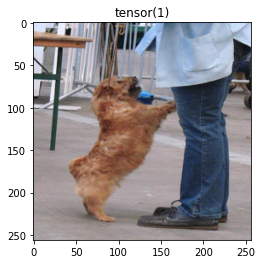

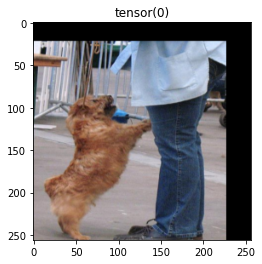

In [259]:
#theta = torch.cat((model.downscale.unsqueeze(0).repeat(
#            theta.size(0), 1, 1), theta.unsqueeze(2)),
#                          dim=2)
        
        #theta = theta.view(-1, 2, 3)
num = 16
img = data[0][num:num+1,...]   
theta = output[1][num:num+1,...]
#theta[0,:,2] = torch.FloatTensor((0,.5))
print(theta)
grid_size = torch.Size([1, 3, 256, 256])
grid = F.affine_grid(theta, grid_size)
img_grid = F.grid_sample(img, grid)
plt.imshow(data[0][num,...].permute(1,2,0).detach().numpy())
plt.title(label[num])
plt.figure()
plt.imshow(img_grid[0,:].permute(1,2,0).detach().numpy())
plt.title(cat[num])

In [ ]:
plt.imshow(data[0][1,:].permute(1,2,0).detach().numpy())

In [ ]:
plt.imshow(output[0][1,:].permute(1,2,0).detach().numpy())

In [ ]:
output[1][1][:,2].detach().numpy()

In [ ]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    return inp

thetas = []
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        
        data, label = next(iter(test_loader))
        data_original = data[0][:16, ...].to(device)
        data_polo = {'in': data[1]['in'][:16, ...].to(device),
                     'out': data[1]['out'][:16, ...].to(device)}
        
        input_tensor = data_original.cpu()
        
        output_tensor, theta = model.stn(data_original, data_polo)
        thetas.append(theta)
        
        #output_tensor = F.pad(input=output_tensor, pad=(50, 50, 50, 50), mode='constant', value=0)

        transformed_input_tensor = output_tensor.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor, nrow=4))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor, nrow=4))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[0].set_xticks([0, 131])
        axarr[0].set_yticks([390])
        axarr[0].set_yticklabels([128])
        axarr[0].set_xticklabels([0, 128])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        axarr[1].set_xticks([0, 30])
        axarr[1].set_yticks([90])
        axarr[1].set_yticklabels([28])
        axarr[1].set_xticklabels([0, 28])

        #f.savefig('../figures/polo_atn_attention.png')

In [ ]:
visualize_stn()

In [ ]:
visualize_stn()

In [ ]:
visualize_stn()

In [ ]:
visualize_stn()